# Import Libraries

In [1]:
import copy
import utils
import torch
import constants
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from env import Env
from agent import Agent
from torchsummary import summary
from torch.distributions import Normal, Categorical

[MAX_POSSIBLE_DIST]: 0.4428093360578569


# Initialise Environment

In [2]:
#initialise environment
min_x, max_x =  -0.110 - 0.150,   -0.110 + 0.150
min_y, max_y =   0.560 - 0.125,    0.560 + 0.125
min_z, max_z =               0,              0.4 

workspace_lim = np.asarray([[min_x, max_x], 
                            [min_y, max_y],
                            [min_z, max_z]])

print(f"workspace space: \n{workspace_lim}")

obj_dir = 'objects/blocks/'
N_obj = 5

env = Env(obj_dir, N_obj, workspace_lim, cluttered_mode= True, is_debug = False)

workspace space: 
[[-0.26   0.04 ]
 [ 0.435  0.685]
 [ 0.     0.4  ]]


# Initialise Agent

In [3]:
agent = Agent(env, 
              max_memory_size = 100000, 
              max_memory_size_rl = 200000,
              max_memory_size_hld = 50000,
              is_debug = True, 
              N_batch = 512, 
              N_batch_hld = 512, 
              lr = 1e-4, 
              hld_lr = 1e-4,
              tau = 0.05,
              tau_hld = 0.05,
              max_action_taken = 50,
              max_result_window = 500,
              max_result_window_hld = 250,
              max_result_window_eval = 100,
              max_stage1_episode = 200,
              N_grasp_step = 25, 
              N_push_step = 25, 
              success_rate_threshold = 0.7,
              checkpt_dir_agent="/media/ryan/Seagate/research_proj_backup/research_2.0/logs/agent", #need to change to your own path
              checkpt_dir_models="/media/ryan/Seagate/research_proj_backup/research_2.0/logs/models", #need to change to your own path
              exp_dir_expert="/media/ryan/Seagate/research_proj_backup/research_2.0/logs/exp_expert", #need to change to your own path
              exp_dir_rl="/media/ryan/Seagate/research_proj_backup/research_2.0/logs/exp_rl", #need to change to your own path
              exp_dir_hld="/media/ryan/Seagate/research_proj_backup/research_2.0/logs/exp_hld") #need to change to your own path

device: cuda
[SUCCESS] initialise environment
[SUCCESS] initialise networks


# Interact

In [4]:
# agent.interact(max_episode = 2000, 
#                hld_mode = constants.HLD_MODE,
#                lla_mode = constants.BC_RL,
#                is_eval = False)

In [5]:
agent.is_eval = False
agent.load_agent_data()

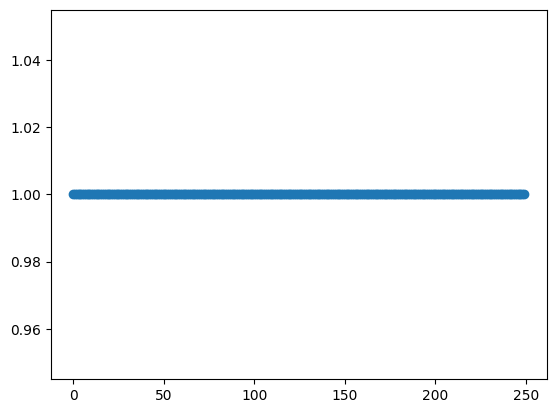

In [6]:
plt.plot(np.array(agent.complete_record_train), 'o')

[HLD ATC] ATC mean: 8.62/8.488 [250]


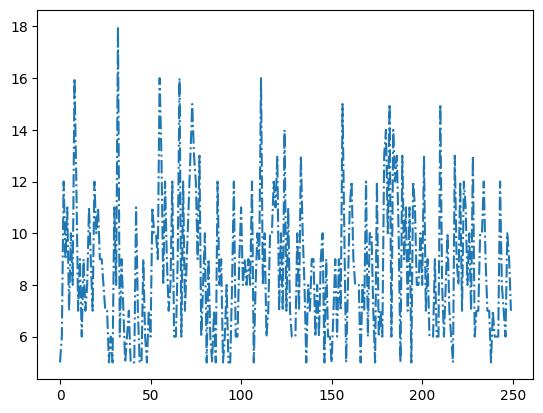

In [7]:
ATC_mean_train = np.sum(agent.action_taken_record_train)/(np.array(agent.action_taken_record_train) > 0).sum()
print(f"[HLD ATC] ATC mean: {ATC_mean_train}/{agent.best_ATC_mean_train} [{agent.max_result_window_hld}]")

plt.plot(agent.action_taken_record_train, '-.')

max ATC: 12.088
min ATC: 8.488


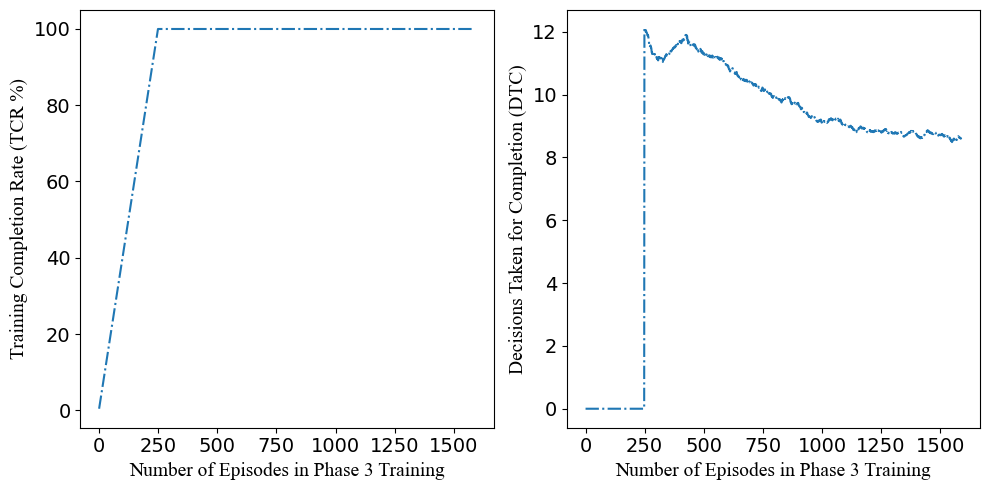

In [49]:
fig, axs = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(10)

fontsize = 14
font = {'fontname':'Times New Roman', 'fontsize': fontsize}

axs[0].plot(np.array(agent.CR_train)*100., '-.')
axs[0].set_xlabel('Number of Episodes in Phase 3 Training', **font)
axs[0].set_ylabel('Training Completion Rate (TCR %)', **font)

axs[1].plot(agent.ATC_train, '-.')
axs[1].set_xlabel('Number of Episodes in Phase 3 Training', **font)
axs[1].set_ylabel('Decisions Taken for Completion (DTC)', **font)

for ax in axs.flat:
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

fig.tight_layout()
print(f'max ATC: {np.array(agent.ATC_train[250:]).max()}')
print(f'min ATC: {np.array(agent.ATC_train[250:]).min()}')

best grasp success rate: 98.6%
best push success rate: 97.8%


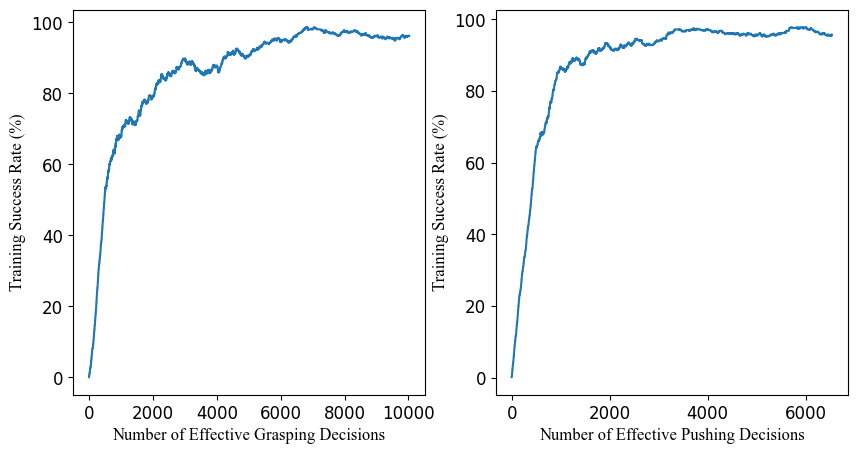

In [50]:
fig, axs = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(10)

fontsize = 12
font = {'fontname':'Times New Roman', 'fontsize': fontsize}

axs[0].plot(np.array(agent.grasp_success_rate_hist)*100.)
axs[0].set_xlabel('Number of Effective Grasping Decisions', **font)
axs[0].set_ylabel('Training Success Rate (%)', **font)

axs[1].plot(np.array(agent.push_success_rate_hist)*100.)
axs[1].set_xlabel('Number of Effective Pushing Decisions', **font)
axs[1].set_ylabel('Training Success Rate (%)', **font)

for ax in axs.flat:
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

print(f'best grasp success rate: {np.array(agent.grasp_success_rate_hist).max()*100.}%')
print(f'best push success rate: {np.array(agent.push_success_rate_hist).max()*100.}%')

In [10]:
agent.episode

2000